# Heiken Ashi Trading Strategy: 1/N vs MPT
This notebook explores the performance of a Heiken Ashi-based trading strategy using two distinct allocation models:
1.  **1/N Allocation (Equal Weight)**: Active assets receive equal portions of the portfolio.
2.  **MPT Allocation (Modern Portfolio Theory)**: Active assets are weighted using mean-variance optimization to maximize the Sharpe ratio.

### Signals:
- **Entry**: First Green Heiken Ashi candle.
- **Exit**: First Red Heiken Ashi candle.


## 0) Setup


In [4]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show

# --- Setup correct working directory (ROOT) ---
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

ROOT = os.getcwd()
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

from src.backtester.data import load_cleaned_assets, align_close_prices
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.metrics import compute_performance_stats
from src.backtester.models import HeikenAshiMicroModel, EqualWeightAllocator, MPTAllocator, combine_models_to_weights
from src.backtester.bokeh_plots import build_interactive_portfolio_layout
from src.backtester.report import compute_backtest_report

output_notebook()


Loading BokehJS ...

## 1) Data Loading


In [5]:
assets = load_cleaned_assets(symbols=None)
close = align_close_prices(assets)

cfg = BacktestConfig(
    initial_equity=1_000_000,
    transaction_cost_bps=5,
    rebalance='D', # Daily rebalance to track optimal weights
    mode='event_driven',
    strict_signals=False # Weight-based tracking
)

model = HeikenAshiMicroModel()
print(f'Loaded {len(assets)} assets.')


Loaded 100 assets.


## 2) 1/N Backtest


In [6]:
print('Computing 1/N Weights...')
w_ew = combine_models_to_weights(assets=assets, micro_model=model, allocator=EqualWeightAllocator())

print('Running 1/N Backtest...')
res_ew = run_backtest(close_prices=close, weights=w_ew, config=cfg)
report_ew = compute_backtest_report(result=res_ew, close_prices=close)
display(report_ew)


Computing 1/N Weights...
Running 1/N Backtest...


Start                         2016-01-25 00:00:00
End                           2026-01-16 00:00:00
Duration                       3644 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       1711801.253497
Equity Peak                        1711801.253497
Total Return [%]                        71.180125
CAGR [%]                                 5.545165
Volatility (ann) [%]                    17.480912
Sharpe                                   0.396287
Sortino                                  0.604015
Max Drawdown [%]                       -38.578511
Calmar                                   0.143737
Best Day [%]                            11.441417
Worst Day [%]                          -11.663266
Avg Gross Exposure                        0.99758
Avg Net Exposure                          0.99758
Exposure Time [%]                       99.721227
Rebalance Days                               2511
Total Turnover                  2463121208.975938


## 3) MPT Backtest


In [7]:
print('Computing MPT Weights (this may take a moment)...')
w_mpt = combine_models_to_weights(assets=assets, micro_model=model, allocator=MPTAllocator(lookback=252))

print('Running MPT Backtest...')
res_mpt = run_backtest(close_prices=close, weights=w_mpt, config=cfg)
report_mpt = compute_backtest_report(result=res_mpt, close_prices=close)
display(report_mpt)


Computing MPT Weights (this may take a moment)...
Running MPT Backtest...


Start                         2016-01-25 00:00:00
End                           2026-01-16 00:00:00
Duration                       3644 days 00:00:00
Initial Equity                          1000000.0
Final Equity                       2019005.813035
Equity Peak                        2019005.813035
Total Return [%]                       101.900581
CAGR [%]                                 7.308797
Volatility (ann) [%]                    19.791251
Sharpe                                   0.455589
Sortino                                  0.707376
Max Drawdown [%]                        -36.20691
Calmar                                   0.201862
Best Day [%]                            11.692516
Worst Day [%]                          -12.690753
Avg Gross Exposure                       0.997616
Avg Net Exposure                         0.997616
Exposure Time [%]                       99.721227
Rebalance Days                               2511
Total Turnover                  2698052450.595593


## 4) Comparison


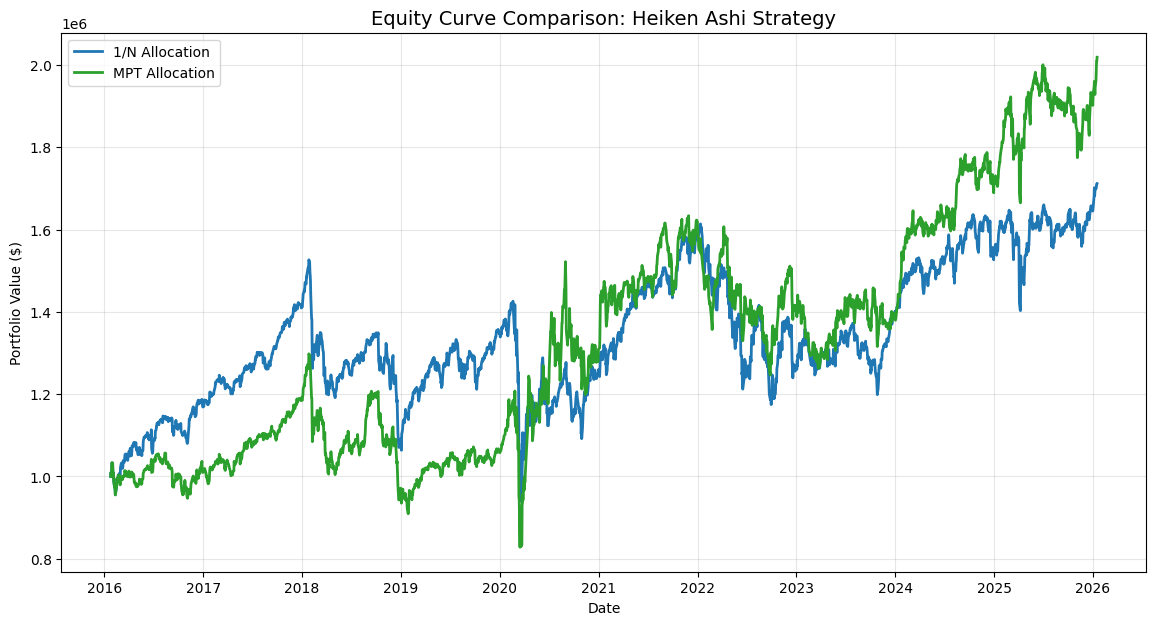

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(res_ew.equity, label='1/N Allocation', color='#1f77b4', linewidth=2)
plt.plot(res_mpt.equity, label='MPT Allocation', color='#2ca02c', linewidth=2)
plt.title('Equity Curve Comparison: Heiken Ashi Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5) Detailed Interactive Analysis (MPT)


In [9]:
def build_market_proxy_ohlcv(assets, index):
    opens = pd.concat([df['Open'].reindex(index).astype(float) for df in assets.values()], axis=1).mean(axis=1)
    highs = pd.concat([df['High'].reindex(index).astype(float) for df in assets.values()], axis=1).mean(axis=1)
    lows = pd.concat([df['Low'].reindex(index).astype(float) for df in assets.values()], axis=1).mean(axis=1)
    closes = pd.concat([df['Close'].reindex(index).astype(float) for df in assets.values()], axis=1).mean(axis=1)
    return pd.DataFrame({'Open': opens, 'High': highs, 'Low': lows, 'Close': closes})

market_df = build_market_proxy_ohlcv(assets, close.index)

layout = build_interactive_portfolio_layout(
    market_ohlcv=market_df,
    equity=res_mpt.equity,
    returns=res_mpt.returns,
    weights=res_mpt.weights,
    turnover=res_mpt.turnover,
    costs=res_mpt.costs,
    close_prices=close,
    title='Heiken Ashi Strategy (MPT Allocation)'
)
show(layout)
